Test whether neg voja with recurrence is more effective for classification than recurrence

In [2]:
import os
from collections import namedtuple

import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import (VecToScalarFeed, meg_from_spikes, numpy_bytes_to_str,
                                         gen_added_strings, norm_spa_vecs)
from nengo_learn_assoc_mem.paths import data_path

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup

In [3]:
with h5py.File(os.path.join(data_path, "neg_voja_weights", "neg_voja_enc.h5"), "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])
    n_neurons = fin_enc.shape[0]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [4]:
with h5py.File(os.path.join(data_path, "neg_voja_weights", "less_base_inhib_match_weights_alt2.h5"), "r") as fi:
    
    rec_weights = np.array(fi['weights'])

In [5]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [6]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [25]:
t_pause = 0.2
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)
td_present = int(t_present/dt)

In [8]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [9]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

## Train

In [10]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

### Analytically

In [11]:
feed = VecToScalarFeed(feed_vecs, list(np.ones(len(feed_vecs))), t_present, t_pause)

with nengo.Network(seed=seed) as train_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)))

    p_in = nengo.Probe(in_nd, synapse=None)
    p_spikes = nengo.Probe(ens.neurons, synapse=None)
    p_cor = nengo.Probe(correct, synapse=None)

with nengo.Simulator(train_model) as train_sim:
    train_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [13]:
solver = nengo.solvers.LstsqL2(reg=0.02)

In [17]:
dec, rmse = solver(train_sim.data[p_spikes], train_sim.data[p_cor])
dec = dec.T

# Test

In [18]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs
correct_out = list(np.ones(len(fan1)+len(fan2))) + list(np.ones(len(foil1) + len(foil2)))

feed = VecToScalarFeed(feed_vecs, correct_out, t_present, t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: -feed.paused)
    output = nengo.Node(size_in=1)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=0.01)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

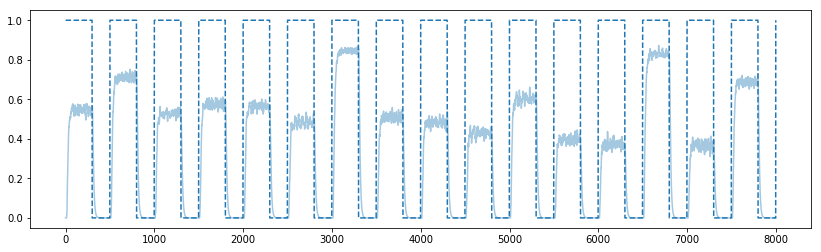

In [19]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.data[p_out][fan1_slc], alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(test_sim.data[p_cor][fan1_slc], linestyle="--")

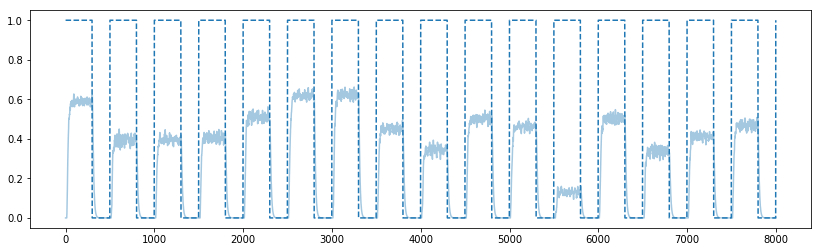

In [20]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.data[p_out][fan2_slc], alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(test_sim.data[p_cor][fan2_slc], linestyle="--")

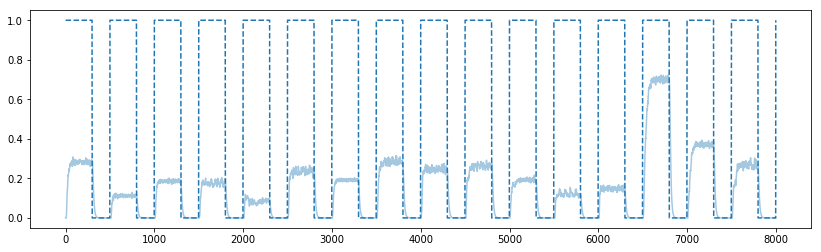

In [21]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.data[p_out][foil1_slc], alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(test_sim.data[p_cor][foil1_slc], linestyle="--")

The recurrence greatly increases the foil response and the output of it's decoding. Training and testing without recurrencence gave the expected response. Not sure what this means...

## Compare reaction times

In [22]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [23]:
def n_ans_conf(comp_res: np.ndarray, num_items: int, td_item: int, td_pres: int) -> np.ndarray:
    ind_ans = comp_res.reshape((td_item, num_items, -1), order='F').squeeze()
    return np.sum(ind_ans[:td_pres], axis=0)

In [26]:
neural_confs = {}
for nm, obj in slc_stim_vecs.items():
    conf_res = n_ans_conf(test_sim.data[p_out][obj.slc], len(obj.vecs), td_each, td_present)
    neural_confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 151.78830931136812
fan2 121.70690607720444
foil1 66.40554288801232
foil2 80.17589916606289


In [27]:
nconf_df = pd.DataFrame(neural_confs)

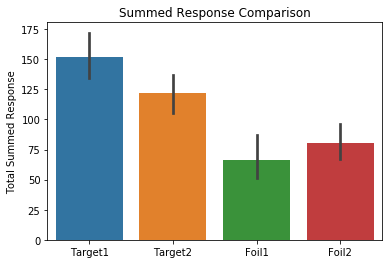

In [28]:
ax = sns.barplot(data=nconf_df)
ax.set_xticklabels(("Target1", "Target2", "Foil1", "Foil2"))
ax.set_ylabel("Total Summed Response")
ax.set_title("Summed Response Comparison");